# Анализ данных осень 2021
# Практический анализ данных и ML соревнования

### Зачем участвтовать

- Полезно для резюме
- Полезно для скорости работы
- Иногда прибыльно
- Полезно для навыков, если вы не kaggle expert

### Чему научили за курс

- Быть линтером питона
- Перекладывать одни колонки данных в другие
    
    выделять признаки в данных, но не ясно какие из них полезны. И для чего полезны
    
- Применять непонятные ML модели к сырым данным

    алгоритмы AutoML делают похожую работу, но подбирают нужные параметры быстрее программистов
    
- Выделять на графиках закономерности, которые понятны без графиков

    сложно найти что-то в данных без цели. Проще предполагать по данным что может быть правдой, а что нет

Вопросы без ответа

- Что считать хорошим анализом данных
- Что делать с плохим количеством данных
- Как смотреть на данные

## Пример с соревнования

Возьмём задачу из VK Cup 2020 года. Нужно:

- разобраться в данных, похожих на логи рекламных компаний соцсети
- придумать алгоритм оценки охвата аудитории
- посмотреть насколько точно предсказывается размер аудитории

**Будет много графиков**

#### Данные

In [1]:
!tree data/raw

‘вагЄвга  Ї Ї®Є
‘ҐаЁ©­л© ­®¬Ґа в®¬ : 00000026 8646:7CC1
D:\STUDY\5SEM\DA\LAB9\DATA\RAW
Џ®¤Ї ЇЄЁ ®вбгвбвўгов 



`users.tsv` - данные об аудитории == пользователях соцсети:
- `user_id`, `sex`, `age`, `city_id`

`history.tsv` - данные о рекламных компаниях:
- `hour` – в какой час пользователь видел объявление
- `cpm` - цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка. 
- `publisher` - площадка, на который пользователь видел рекламу
- `user_id`

`validate_answers.tsv` - данные об охвате аудитории рекламной компании:
- `at_least_one` - доля пользователей, которая увидит объявление **хотя бы 1 раз**
- `at_least_two` - доля пользователей, которая увидит объявление **хотя бы 2 раза**
- `at_least_three` - доля пользователей, которая увидит объявление **хотя бы 3 раза**

### Разберёмся в данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 3]

#### О пользователях

In [3]:
users = pd.read_csv('data/raw/users.csv')
print(f'dataset shape: {users.shape}')
users.head(7)

dataset shape: (27769, 4)


,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4
5,5,2,22,5
6,6,1,21,6


<AxesSubplot:>

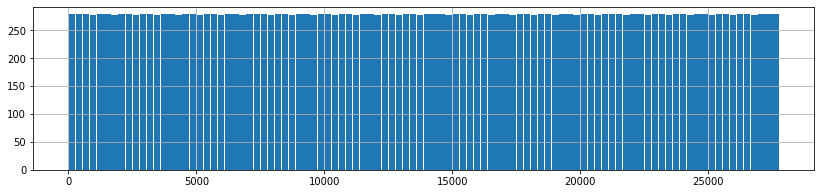

In [4]:
# Пользователи с какими id есть в данных?

users.user_id.hist(bins=100, rwidth=0.9)

<AxesSubplot:>

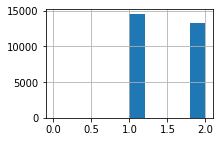

In [5]:
# Пол пользователей

users.sex.hist(figsize=(3, 2))

<AxesSubplot:>

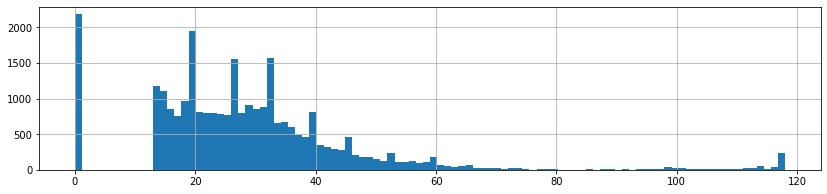

In [6]:
# Возраст

users.age.hist(bins=100)

<AxesSubplot:>

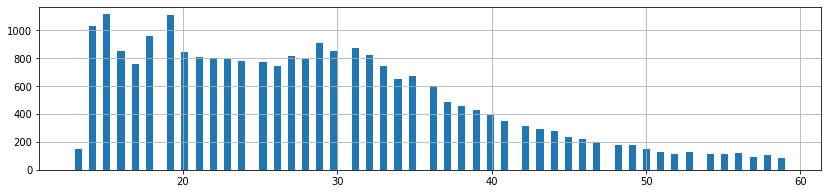

In [7]:
# Возраст основной аудитории

users[(users.age > 0) & (users.age < 60)].age.hist(bins=100)

Количество городов: 2457


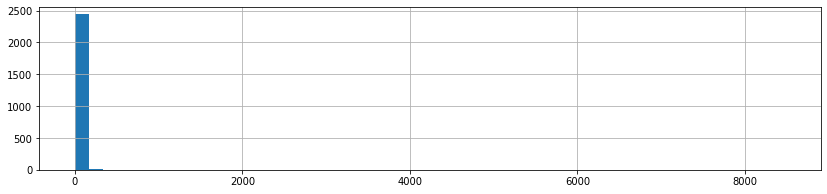

In [8]:
# Города пользователей

print(f'Количество городов: {len(users.city_id.unique())}')
# Сколько пользователей в каждом городе
vc = users.value_counts('city_id')
vc.hist(bins=50)
big_city = set(vc.head(3).index)

<AxesSubplot:>

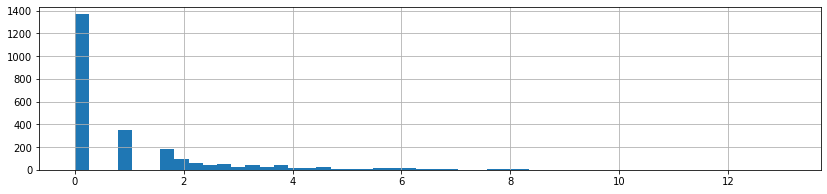

In [9]:
# Логарифмированное количество жителей городов
log2_vc = np.log2(vc)
log2_vc.hist(bins=50)

##### Менее тривиальные графики

<AxesSubplot:>

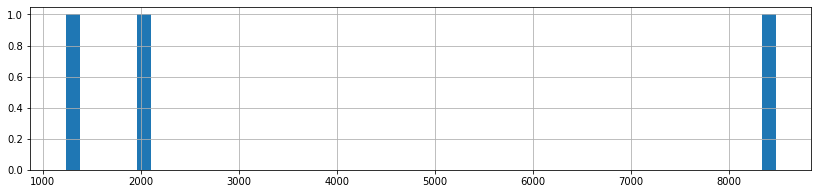

In [10]:
# Города с населением более 1к
vc[vc > 1000].hist(bins=50)

In [11]:
# Исследуем жителей больших городов
vc[vc > 1000]

city_id
0    8479
3    1985
7    1232
dtype: int64

In [12]:
cities_users = users[users.city_id.isin([0, 3, 7])]
cities_users.shape

(11696, 4)

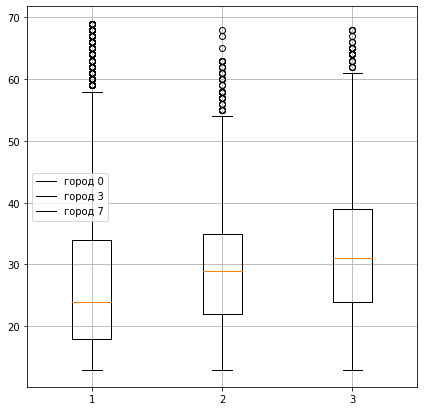

In [13]:
# Их возраст по городам

city_ages = cities_users[(cities_users.age > 0) & (cities_users.age < 70)].groupby('city_id').age.apply(list)

plt.figure(figsize=(7, 7))
plt.boxplot(city_ages)
plt.grid(True)
plt.legend([f'город {city_id}' for city_id in city_ages.index])
plt.show()

#### О рекламных компаниях

In [14]:
history = pd.read_csv('data/raw/history.csv')
print(history.shape)
mean_cpm = np.mean(history.cpm)
# history[history['cpm'] > mean_cpm].size
history.head()

(1147857, 4)


,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


<AxesSubplot:>

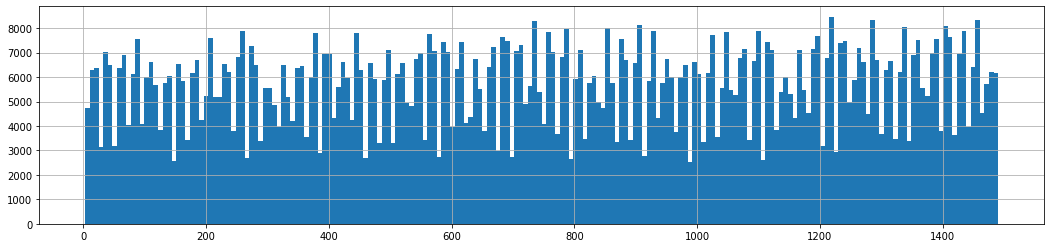

In [15]:
# Время объявлений в ходе всего периода сбора данных
history.hour.hist(bins=200, figsize=(18, 4))

<AxesSubplot:>

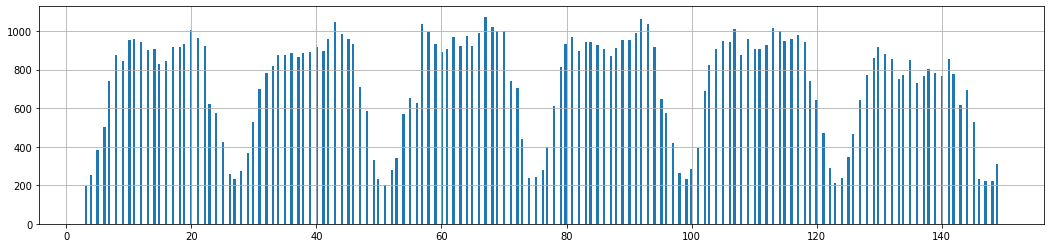

In [16]:
# Подробнее
history[history.hour < 150].hour.hist(bins=400, figsize=(18, 4))

<AxesSubplot:>

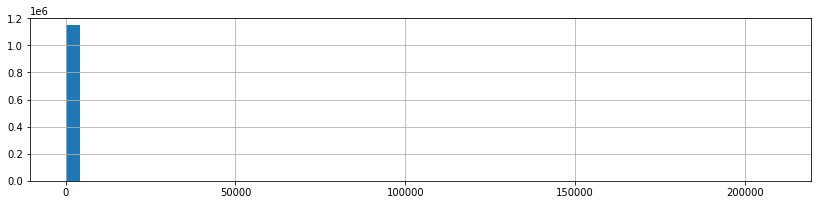

In [17]:
# Цены объявлений
history.cpm.hist(bins=50)

<AxesSubplot:>

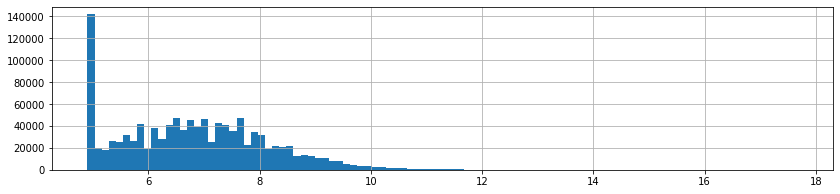

In [18]:
# Логарифмированные
cpms = history.cpm.apply(np.log2)
cpms.hist(bins=100)

<AxesSubplot:>

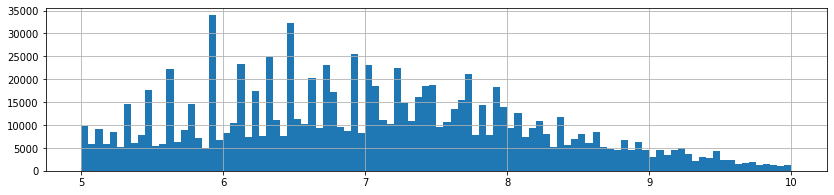

In [19]:
# Подробнее 
cpms[(cpms > 5) & (cpms < 10)].hist(bins=100)

In [20]:
# Что за платформы для рекламы? Сколько их?

print(len(history.publisher.unique()))
vc = history.publisher.value_counts()
big_publishers = set(vc.head(4).index)
big_publishers
# vc.hist(bins=50)
# plt.xlabel('Количество объявлений')
# plt.ylabel('Количество таких платформ')

21


{1, 2, 3, 7}

Text(0, 0.5, 'Количество платформ')

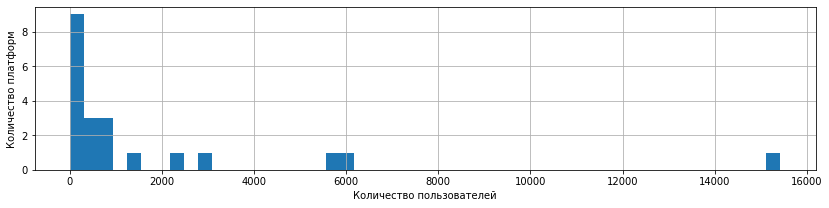

In [21]:
# Сколько уникальных пользователей на платформах?

history.groupby('publisher').user_id.apply(lambda user_ids: len(set(user_ids))).hist(bins=50)
plt.xlabel('Количество пользователей')
plt.ylabel('Количество платформ')

In [22]:
# Какой трафик на каждой платформе?

# Посчитаем для каждого часа: сколько постов было на каждой платформе?

n_publishers = len(history.publisher.unique())
posts_per_hour_by_publishers = []
TAKE_FIRST_N_HOURS = 24 * 4

for hour, hour_data in history[history.hour < TAKE_FIRST_N_HOURS].groupby('hour'):
    publishers_posts = hour_data.value_counts('publisher')
    
    counts = [0 for _ in range(n_publishers)]
    for pub_id, posts_n in list(publishers_posts.items()):
        counts[pub_id-1] = posts_n
        
    posts_per_hour_by_publishers.append([hour] + counts)

    
df = pd.DataFrame.from_records(posts_per_hour_by_publishers, columns=['hour'] + list(history.publisher.unique()))
df.head()

,hour,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,21,20
0,3,100,67,11,1,3,1,7,0,2,...,0,0,0,0,2,1,0,0,0,0
1,4,173,51,10,0,1,1,11,1,2,...,1,0,0,0,1,0,0,0,0,0
2,5,246,91,21,1,1,4,12,3,2,...,2,1,0,0,0,0,0,0,0,0
3,6,346,95,27,2,0,5,16,1,4,...,0,0,0,0,1,1,0,0,0,0
4,7,488,157,29,2,5,5,42,3,6,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Количество постов')

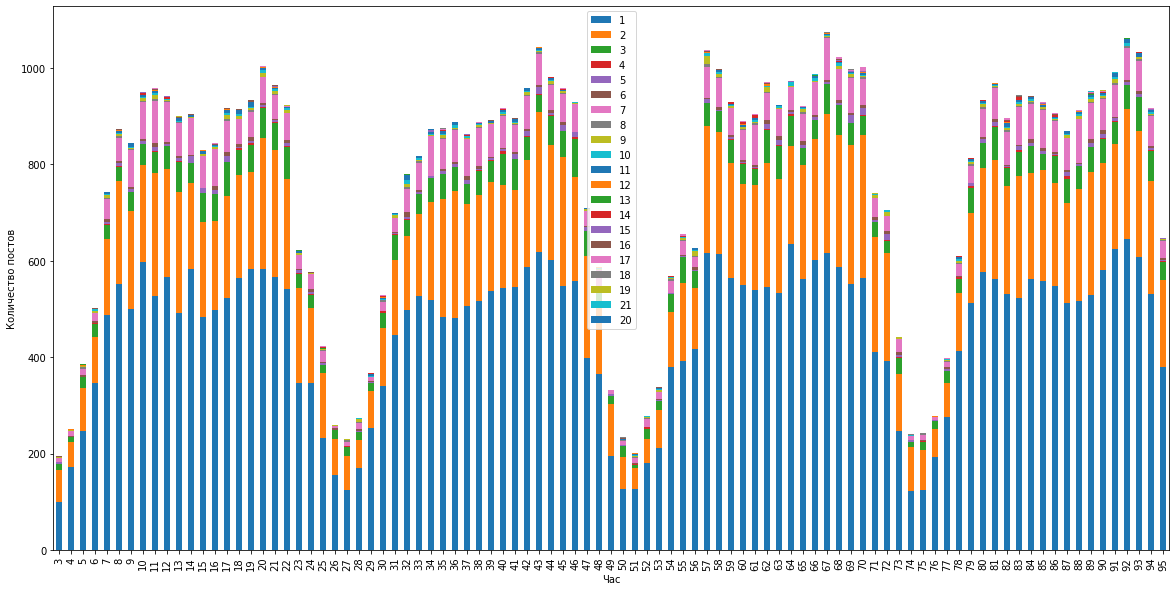

In [23]:
df.plot.bar(x='hour', stacked=True, figsize=(20, 10))
plt.xlabel('Час')
plt.ylabel('Количество постов')

<AxesSubplot:>

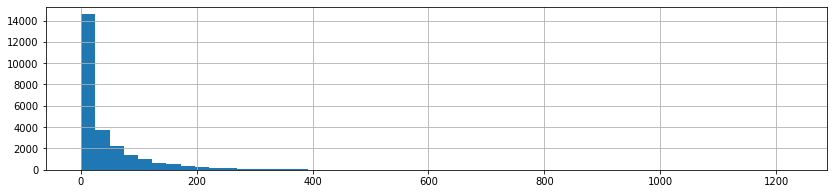

In [24]:
# И сколько постов посмотрел каждый пользователь?
vc = history.value_counts('user_id')
vc.hist(bins=50)

Text(0, 0.5, 'Количество таких пользователей')

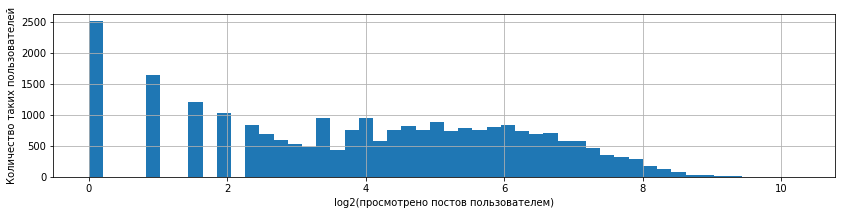

In [25]:
# Логарифмируем
np.log2(vc).hist(bins=50)
plt.xlabel('log2(просмотрено постов пользователем)')
plt.ylabel('Количество таких пользователей')

#### Об результате рекламных компаний

In [26]:
posts = pd.read_csv('data/raw/ads.csv', converters={'user_ids': lambda s: list(map(int, s.split(","))),
                                                    'publishers': lambda s: list(map(int, s.split(",")))})
posts.head(2)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",0
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",1


<AxesSubplot:>

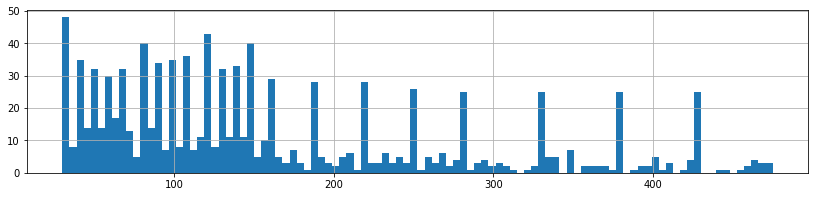

In [27]:
# Сколько по итогам аукциона стоит объявление
posts.cpm.hist(bins=100)

<AxesSubplot:>

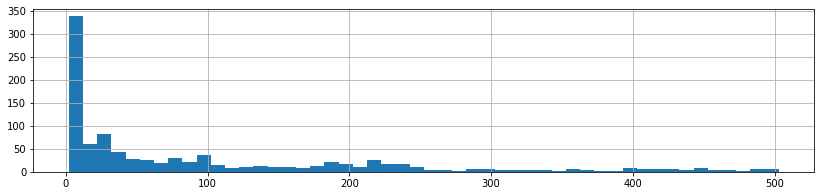

In [28]:
# Сколько часов длится рекламная компания

duration = (posts.hour_end - posts.hour_start)
duration.hist(bins=50)

Text(0, 0.5, 'количество объявлений')

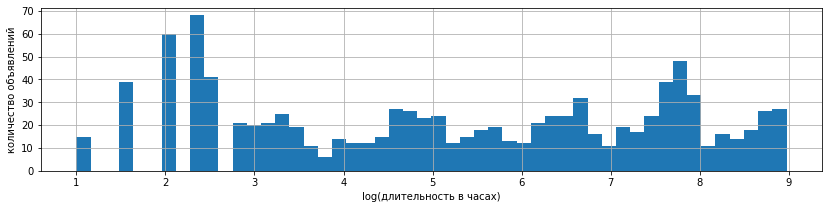

In [29]:
np.log2(duration).hist(bins=50)
plt.xlabel('log(длительность в часах)')
plt.ylabel('количество объявлений')

<AxesSubplot:>

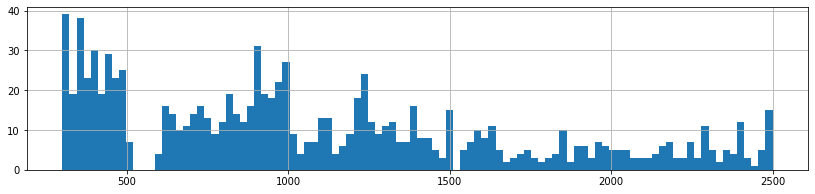

In [30]:
# На какую аудиторию крутилось объявление

posts.audience_size.hist(bins=100)

#### Об охвате

In [31]:
answers = pd.read_csv('data/raw/target.csv')
answers.head(7)

,ad_id,at_least_one
0,0,0.0430
1,1,0.0130
2,2,0.0878
3,3,0.2295
4,4,0.3963
5,5,0.0187
6,6,0.3839


<AxesSubplot:>

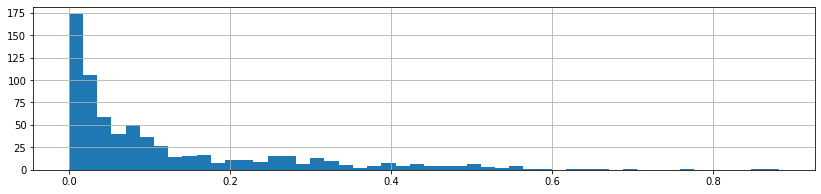

In [32]:
# Какая часть аудитории увидело объявление хоть раз
answers.at_least_one.hist(bins=50)

Если у вас нет непонимания и вопросов о данных, то вы посмотрели хороший анализ данных. Возможно выше неплохой анализ

### Построим модель

#### Выделим числовые признаки

In [33]:
import seaborn as sns

In [34]:
# Соберём простую информацию по каждому объявлению в датасет
solution = pd.read_csv('data/raw/sample_solution.csv')
answers2 = answers.append(solution)
ads = pd.merge(posts, answers2, on='ad_id')
ads.head(2)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id,at_least_one
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",0,0.043
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",1,0.013


In [36]:
# Добавим пару простых признаков

def cnt_sex1 (arr) :
    cnt = 0
    for i in arr :
        if users.iloc[i]['sex'] == 1:
            cnt += 1
    return cnt

def mean_age (arr) :
    return np.mean(list(map(lambda user_id: users.iloc[user_id]['age'], arr)))

def cnt_big_publishers (arr) :
    cnt = 0
    for i in arr :
        if big_publishers.__contains__(i):
            cnt += 1
    return cnt

def cnt_big_citizens (arr) :
    cnt = 0
    for i in arr :
        if big_city.__contains__(users.iloc[i]['city_id']):
            cnt += 1
    return cnt

def cnt_users_for_cpm (cpm) :
    return history[history['cpm'] <= cpm].user_id.value_counts().size

def cnt_target_users_cpm(cpm, list_users) :
    possible_users=history[history['cpm'] <= cpm].user_id.value_counts().index.array
    set_target_users=set(list_users)
    return len(list(filter(lambda user: set_target_users.__contains__(user), possible_users)))

def cnt_target_users_hour(start, end, list_users) :
    possible_users=history[(start <= history['hour']) & (history['hour'] <= end)].user_id.value_counts().index.array
    set_target_users=set(list_users)
    return len(list(filter(lambda user: set_target_users.__contains__(user), possible_users)))

ads = ads.assign(
    n_publishers=ads.publishers.apply(lambda s: len(s)),
    duration=ads.hour_end - ads.hour_start,
    sex1=ads.user_ids.apply(cnt_sex1),
    mean_age=ads.user_ids.apply(mean_age),
    big_publishers=ads.publishers.apply(cnt_big_publishers),
    big_citizens=ads.user_ids.apply(cnt_big_citizens),
    cnt_users_for_cpm=ads.cpm.apply(cnt_users_for_cpm),
    cnt_target_users_cpm=list(map(cnt_target_users_cpm, ads.cpm, ads.user_ids)),
    cnt_target_users_hour=list(map(cnt_target_users_hour, ads.hour_start, ads.hour_end, ads.user_ids))
)

useful_columns = [
 'cpm',
 'duration',
 'n_publishers',
 'audience_size',
 'sex1',
 'mean_age',
 'big_publishers',
 'big_citizens',
 'cnt_users_for_cpm',
 'cnt_target_users_cpm',
 'cnt_target_users_hour',
 'at_least_one'
]

ads = ads[useful_columns]
ads.head()

,cpm,duration,n_publishers,audience_size,sex1,mean_age,big_publishers,big_citizens,cnt_users_for_cpm,cnt_target_users_cpm,cnt_target_users_hour,at_least_one
0,220.0,95,2,1906,1025,28.721406,1,0,22908,1594,999,0.0430
1,312.0,6,2,1380,735,28.611594,1,507,23922,1376,245,0.0130
2,70.0,20,6,888,473,29.055180,3,361,17446,561,245,0.0878
3,240.0,82,2,440,240,27.763636,1,0,23143,364,213,0.2295
4,262.0,238,4,1476,903,44.760840,3,589,23461,1181,909,0.3963


In [37]:
def heatmap(data: pd.DataFrame):
    plt.figure(figsize=(10, 9))
    sns.heatmap(data.corr(), square=True, linecolor='white', annot=True)
    plt.yticks(rotation=30)
    plt.xticks(rotation=30)
    plt.show()

<Figure size 720x648 with 0 Axes>

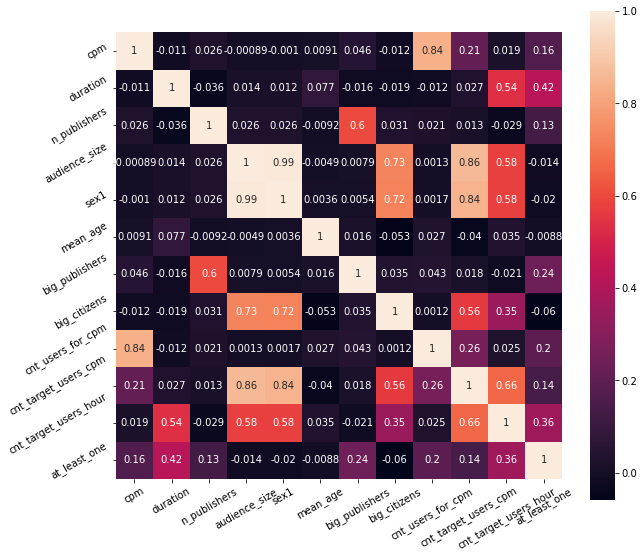

In [38]:
plt.figure(figsize=(10, 9))
heatmap(ads)

<Figure size 720x648 with 0 Axes>

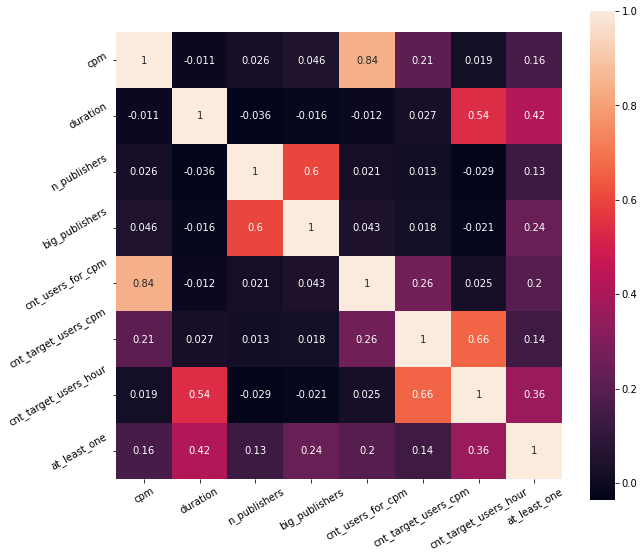

In [39]:
#sex1 is useless
ads = ads.drop('sex1', axis=1)
ads = ads.drop('audience_size', axis=1)
ads = ads.drop('mean_age', axis=1)
ads = ads.drop('big_citizens', axis=1)
plt.figure(figsize=(10, 9))
heatmap(ads)

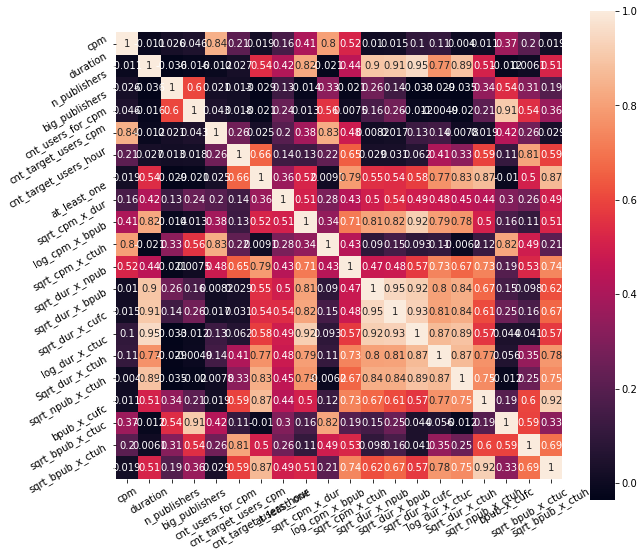

In [40]:
# Добавим дата саенс

# ads_featured = ads.assign(
#     log_dur_x_ctuh=np.sqrt(ads.duration*ads.cnt_target_users_hour),
#     sqrt_cpm_x_dur=np.sqrt(ads.cpm*ads.duration),
#     log_bpub_x_cufc=np.log(ads.big_publishers*ads.cnt_users_for_cpm),
#     log_cpm_x_ctuh=np.sqrt(ads.cpm*ads.cnt_target_users_hour),
#     sqrt_bpub_x_dur=np.sqrt(ads.big_publishers*ads.duration),
# )
ads_featured = ads.assign(
	sqrt_cpm_x_dur=np.sqrt(ads.cpm*ads.duration),
	# log_cpm_x_npub=np.log(ads.cpm*ads.n_publishers),
	log_cpm_x_bpub=np.log(ads.cpm*ads.big_publishers),
	# log_cpm_x_cufc=np.log(ads.cpm*ads.cnt_users_for_cpm),
	# log_cpm_x_ctuc=np.log(ads.cpm*ads.cnt_target_users_cpm),
	sqrt_cpm_x_ctuh=np.sqrt(ads.cpm*ads.cnt_target_users_hour),
	sqrt_dur_x_npub=np.sqrt(ads.duration*ads.n_publishers),
	sqrt_dur_x_bpub=np.sqrt(ads.duration*ads.big_publishers),
	sqrt_dur_x_cufc=np.sqrt(ads.duration*ads.cnt_users_for_cpm),
	log_dur_x_ctuc=np.log(ads.duration*ads.cnt_target_users_cpm),
	Sqrt_dur_x_ctuh=np.sqrt(ads.duration*ads.cnt_target_users_hour),
	# sqrt_npub_x_bpub=np.sqrt(ads.n_publishers*ads.big_publishers),
	# npub_x_cufc=ads.n_publishers*ads.cnt_users_for_cpm,
	# sqrt_npub_x_ctuc=np.sqrt(ads.n_publishers*ads.cnt_target_users_cpm),
	sqrt_npub_x_ctuh=np.sqrt(ads.n_publishers*ads.cnt_target_users_hour),
	bpub_x_cufc=ads.big_publishers*ads.cnt_users_for_cpm,
    #
	sqrt_bpub_x_ctuc=np.sqrt(ads.big_publishers*ads.cnt_target_users_cpm),
	sqrt_bpub_x_ctuh=np.sqrt(ads.big_publishers*ads.cnt_target_users_hour),
    #
	# log_cufc_x_ctuc=np.log(ads.cnt_users_for_cpm*ads.cnt_target_users_cpm),
	# sqrt_cufc_x_ctuh=np.sqrt(ads.cnt_users_for_cpm*ads.cnt_target_users_hour),
	# log_ctuc_x_ctuh=np.sqrt(ads.cnt_target_users_cpm*ads.cnt_target_users_hour),
)
heatmap(ads_featured)

#### Обучим линейную регрессию

In [41]:
from typing import Tuple
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNet, Lars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression
from sklearn.model_selection import train_test_split

In [42]:
def make_xy(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    x = data.drop('at_least_one', axis=1)
    y = data['at_least_one']
    return x, y

In [43]:
def mape(pred: np.ndarray, trueth: np.ndarray) -> np.ndarray:
    # mean_absolute_percentage_error with clipping huge values
    err = np.array(abs(pred - trueth) / trueth)
    err[err > 20] = 20 # clip 2000% error
    return err

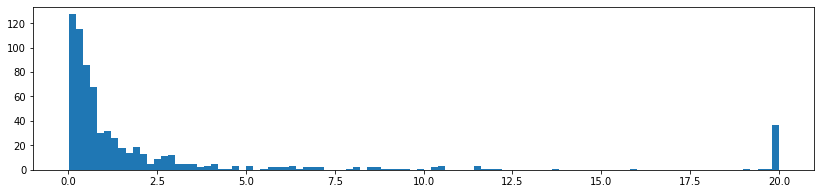

Ошибка на train: 2.4861719168880727


In [44]:
train, test = train_test_split(ads_featured, train_size=700, shuffle=False)

# Обучим модель
x, y = make_xy(train)
model = LinearRegression().fit(x, y)
# model = Lasso(alpha=0).fit(x, y)
# model = Ridge(alpha=-100).fit(x, y)
# model = RidgeCV(alphas=np.logspace(1, -100, 1)).fit(x, y)
# model = ElasticNet(alpha=0, l1_ratio=0).fit(x, y)
# model = Lars(n_nonzero_coefs=1000, normalize=False).fit(x, y)
# model = OrthogonalMatchingPursuit(n_nonzero_coefs=16, normalize=False).fit(x, y)
# model = BayesianRidge().fit(x, y)
# model = ARDRegression().fit(x, y)

# Оценим ошибку
errors = mape(model.predict(x), y)
plt.hist(errors, bins=100)
plt.show()
print('Ошибка на train:', errors.mean())

# Оценим ошибку на тесте
x, y = make_xy(test)
predicted = model.predict(x)
submission = solution
submission['at_least_one'] = predicted

In [45]:
submission.to_csv('data/raw/submission.csv', index=False)
# solution
# submission = pd.read_csv('data/raw/submission.csv')
# errors = mape(submission.at_least_one.array, y)
# plt.hist(errors, bins=100)
# print('Ошибка на test:', errors.mean())

### Насколько вообще разделимы данные?

In [46]:
import umap

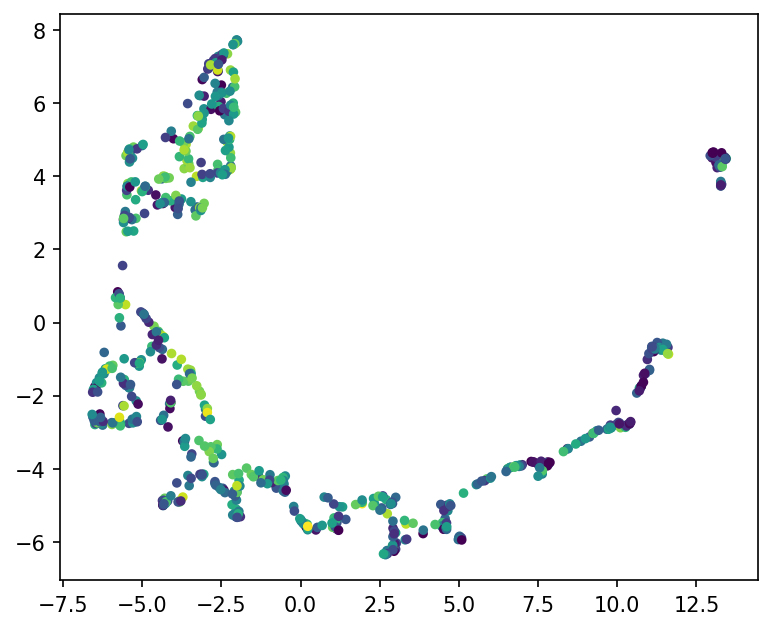

In [47]:
# Покажем похожие объявления точками, а охват цветом
embedding = umap.UMAP().fit_transform(ads[[
 'cpm',
 'duration',
 'n_publishers',
 'big_publishers',
 'cnt_users_for_cpm',
 'cnt_target_users_cpm',
 'cnt_target_users_hour',
]].head(700))

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads.at_least_one.head(700) * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)

D:\study\5sem\DA\lab9\venv\lib\site-packages\umap\spectral.py:227: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  warn(


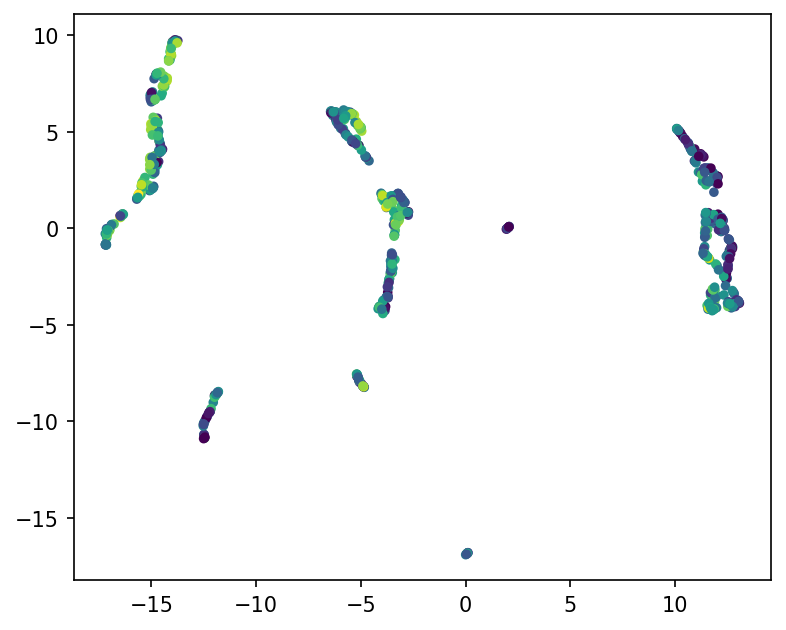

In [49]:
# Покажем похожие объявления точками, а охват цветом. Но на данных с доп фичами
embedding = umap.UMAP().fit_transform(ads_featured[[
 'cpm',
 'duration',
 'n_publishers',
 'big_publishers',
 'cnt_users_for_cpm',
 'cnt_target_users_cpm',
 'cnt_target_users_hour',
 'sqrt_cpm_x_dur',
 'log_cpm_x_bpub',
 'sqrt_cpm_x_ctuh',
 'sqrt_dur_x_npub',
 'sqrt_dur_x_bpub',
 'sqrt_dur_x_cufc',
 'log_dur_x_ctuc',
 'Sqrt_dur_x_ctuh',
 'sqrt_npub_x_ctuh',
 'bpub_x_cufc',
 'sqrt_bpub_x_ctuc',
 'sqrt_bpub_x_ctuh',
]].head(700))

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads_featured.at_least_one.head(700) * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)

## Конец первой части курса